## Code / Implementation of methods
### Import all the libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statistics
from sklearn.svm import SVC
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read Recharge, Voice, Data usage and SMS data from the csv files for 63960 entity IDs

In [2]:
data = pd.read_csv('rechargeANDvoice.csv')
data_SMS = pd.read_csv('Data_SMS_0.csv')

data_SMS = data_SMS.replace("u\'", "\"", regex = True )
data_SMS = data_SMS.replace("\':", "\":", regex = True )
data_SMS = data_SMS.replace("\'}", "\"}", regex = True )

data = data.replace("u\'", "\"", regex = True )
data = data.replace("\':", "\":", regex = True )
data = data.replace("\'}", "\"}", regex = True )

data = data.merge( data_SMS, on="EntityIds" )
data['ChurnedTimestamp'] = 0
data['isChurned'] = 0
data['rejectInsuffData'] = 0
del data["Unnamed: 0_y"]
del data["Unnamed: 0_x"]

### Feature Selection  
Features considered for each time series / Entity ID
Mean  
Variance  
Min  
Max  
Number of Inactive days  
using the following Time Series -   
Voice Call Time Series - Number of calls per day  
SMS Time Series – Number of SMS per day  
Data Time Series – Data used in KB per day  
Recharge Time Series - Amount and time of a pre-paid account recharge  
Carrier Reported Subscription State Delta Time Series – Tells whether an entity ID active or inactive. Needed for churn  
### Removing NA / Null values 
Create new column with rejectInsuffData to reject entity IDs with missing data
### Finding the churners and non-churners
Create new column with isChurned - 0 if not churned and 1 if churned

In [3]:
count = 0

for i in range(len(data)):
    if ( i % 10000 == 0):
        print(i)
    row = data.iloc[i]
    DeltaTimeSeries = row['DeltaTimeSeries']
    if pd.isnull(DeltaTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    DeltaTimeSeries = json.loads(DeltaTimeSeries)
    if not DeltaTimeSeries:
        data.loc[i,'rejectInsuffData'] = 1
        continue
    
    RechargeTimeSeries = row['RechargeTimeSeries']
    if pd.isnull(RechargeTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    RechargeTimeSeries = json.loads(RechargeTimeSeries)
    if not RechargeTimeSeries:
        data.loc[i,'rejectInsuffData'] = 1
        continue

    VoiceCallTimeSeries = row['VoiceCallTimeSeries']
    if pd.isnull(VoiceCallTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    VoiceCallTimeSeries = json.loads(VoiceCallTimeSeries)
    if not VoiceCallTimeSeries:
        data.loc[i,'rejectInsuffData'] = 1
        continue

    DataTimeSeries = row['DataTimeSeries']
    if pd.isnull(DataTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    DataTimeSeries = json.loads(DataTimeSeries)
    if not DataTimeSeries:
        data.loc[i,'rejectInsuffData'] = 1
        continue
    
    SMSTimeSeries = row['SMSTimeSeries']
    if pd.isnull(SMSTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    SMSTimeSeries = json.loads(SMSTimeSeries)
    if not SMSTimeSeries:
        data.loc[i,'rejectInsuffData'] = 1
        continue

    cool_counter = 0
    coolingTimeStamp = 0
    for record in DeltaTimeSeries:
        if( record['value'] == 'COOLING'):
            if cool_counter > 0:
                print('cooling more than once for', row['EntityIds'])
                if coolingTimeStamp < record['timestamp']:
                    coolingTimeStamp = record['timestamp']
                    data.loc[i, 'ChurnedTimestamp'] = str(coolingTimeStamp)
            else:
                coolingTimeStamp = record['timestamp']
                data.loc[i, 'ChurnedTimestamp'] = str(coolingTimeStamp)
                data.loc[i, 'isChurned'] = 1
            cool_counter = cool_counter + 1


    x = []
    y = []
    for record in SMSTimeSeries:
        x.append(int(record['timestamp']))
        y.append(int(record['value']))    
    
    if len(y) > 2:
        data.loc[i, 'var_SMS'] = statistics.variance(y)
    data.loc[i, 'min_SMS'] = min(y)
    data.loc[i, 'max_SMS'] = max(y)
    data.loc[i, 'mean_SMS'] = statistics.mean(y)

    youngest = max(dt for dt in x)
    converted_d1 = datetime.datetime.fromtimestamp((youngest)/1000)
    # last date 27th sept 2017
    converted_d2 = datetime.datetime.fromtimestamp(1506556800)
    if coolingTimeStamp:  
        converted_d2 = datetime.datetime.fromtimestamp((coolingTimeStamp)/1000)
    data.loc[i, 'difference_sms'] = ((converted_d2 - converted_d1).days)        

    
    x = []
    y = []
    
    for record in DataTimeSeries:
        x.append(int(record['timestamp']))
        y.append(int(record['value']))    
    
    if len(y) > 2:
        data.loc[i, 'var_Data'] = statistics.variance(y)
    data.loc[i, 'min_Data'] = min(y)
    data.loc[i, 'max_Data'] = max(y)
    data.loc[i, 'mean_Data'] = statistics.mean(y)
    
    
    youngest = max(dt for dt in x)
    converted_d1 = datetime.datetime.fromtimestamp((youngest)/1000)
    # last date 27th sept 2017
    converted_d2 = datetime.datetime.fromtimestamp(1506556800)
    if coolingTimeStamp:  
        converted_d2 = datetime.datetime.fromtimestamp((coolingTimeStamp)/1000)
    data.loc[i, 'difference_data'] = ((converted_d2 - converted_d1).days)        
    
    x = []
    y = []
    for record in VoiceCallTimeSeries:
        x.append(int(record['timestamp']))
        y.append(int(record['value']))    
    
    if len(y) > 2:
        data.loc[i, 'var_Voice'] = statistics.variance(y)
    data.loc[i, 'min_Voice'] = min(y)
    data.loc[i, 'max_Voice'] = max(y)
    data.loc[i, 'mean_Voice'] = statistics.mean(y)

    youngest = max(dt for dt in x)
    converted_d1 = datetime.datetime.fromtimestamp((youngest)/1000)
    # last date 27th sept 2017
    converted_d2 = datetime.datetime.fromtimestamp(1506556800)
    if coolingTimeStamp:  
        converted_d2 = datetime.datetime.fromtimestamp((coolingTimeStamp)/1000)
    data.loc[i, 'difference_voice'] = ((converted_d2 - converted_d1).days)        


0
10000
20000
30000
cooling more than once for 99d59b20f8526dee74e281de31907239
40000
cooling more than once for 8f6e96d67997ab1195f3afb6a62e7a79
50000
cooling more than once for 72a6ae7d6fa6e7cd0e90ede9ef7998fa
60000


### Rejecting users who have insufficient data 

In [4]:
data_churned = data[data.rejectInsuffData == 0]
data_churned = data_churned.reset_index()
del data_churned['index']

### Rejecting users based on the following flow and criteria:  
1. Removing NA / Null values
2. Removing users who have activity after they have churned (from churned users only)
3. Data Balancing: Data is biased - 96% non churn and 4% churn / Removed the class bias by using 50-50 split


In [5]:
data_new = data_churned.dropna()
data_new = data_new.reset_index()

data_new = data_new[(data_new['difference_voice'] >= 0) & (data_new['difference_data'] >= 0) & (data_new['difference_sms'] >= 0)]

dataChurned = data_new[ data_new.isChurned == 1]
dataNonChurned = data_new[ data_new.isChurned == 0]
dataNonChurned = dataNonChurned.sample(n = len(dataChurned))
data_new = pd.concat([ dataChurned, dataNonChurned ])

print('Total users after Data Balancing: Data is biased - 96% non churn and 4% churn Removed the class bias by using 50-50 split', data_new.shape)

Total users after Data Balancing: Data is biased - 96% non churn and 4% churn Removed the class bias by using 50-50 split (3788, 25)


### Modeling
Create input and output vectors

In [7]:
y = data_new.isChurned

x_without_inactive_days = pd.DataFrame({'mean_SMS': data_new.mean_SMS,
                                        'var_SMS': data_new.var_SMS, 
                                        'min_SMS' : data_new.min_SMS, 
                                        'max_SMS' : data_new.max_SMS, 
                                        'mean_Data' : data_new.mean_Data, 
                                        'var_Data' : data_new.var_Data, 
                                        'min_Data' : data_new.min_Data, 
                                        'max_Data' : data_new.max_Data, 
                                        'mean_Voice' : data_new.mean_Voice, 
                                        'var_Voice' : data_new.var_Voice, 
                                        'min_Voice' : data_new.min_Voice, 
                                        'max_Voice' : data_new.max_Voice})

x_with_inactive_days = pd.DataFrame({'mean_SMS': data_new.mean_SMS,
                  'var_SMS': data_new.var_SMS, 
                  'min_SMS' : data_new.min_SMS, 
                  'max_SMS' : data_new.max_SMS, 
                  'mean_Data' : data_new.mean_Data, 
                  'var_Data' : data_new.var_Data, 
                  'min_Data' : data_new.min_Data, 
                  'max_Data' : data_new.max_Data, 
                  'mean_Voice' : data_new.mean_Voice, 
                  'var_Voice' : data_new.var_Voice, 
                  'min_Voice' : data_new.min_Voice, 
                  'max_Voice' : data_new.max_Voice, 
                  'difference_voice' : data_new.difference_voice, 
                  'difference_data' : data_new.difference_data, 
                  'difference_sms' : data_new.difference_sms})


### KNN

In [8]:
std_scale_x = preprocessing.StandardScaler().fit(x_with_inactive_days)
x = std_scale_x.transform(x_with_inactive_days)
auc = []
accuracy = []
f1 = []
recall = []
precision = []
k_neighbors = []
splits = 10

sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.25)
for K in range(2, 10):
    temp_auc = []
    temp_accuracy = []
    temp_f1 = []
    temp_recall = []
    temp_precision = []
    for train_index, test_index in sss.split(x, y):
        X_train, X_dev = x[train_index], x[test_index]
        Y_train, Y_dev = y.iloc[train_index], y.iloc[test_index]

        neigh = KNeighborsClassifier(n_neighbors=K)
        neigh.fit(X_train, Y_train) 
        y_pred = neigh.predict(X_dev)
        
        tn, fp, fn, tp = confusion_matrix(Y_dev, y_pred).ravel()
        Precision = tp/(tp+fp)
        Recall = tp/(tp+fn)
        F1 = 2 * (Precision * Recall) / (Precision + Recall)
        fpr, tpr, thresholds = metrics.roc_curve(Y_dev, y_pred)
        temp_auc.append(metrics.auc(fpr, tpr))
        temp_accuracy.append(accuracy_score(Y_dev, y_pred))
        temp_f1.append(F1)
        temp_recall.append(Recall)
        temp_precision.append(Precision)
    
    auc.append(np.mean(temp_auc))
    accuracy.append(np.mean(temp_accuracy))
    f1.append(np.mean(temp_f1))
    recall.append(np.mean(temp_recall))
    precision.append(np.mean(temp_precision))
    k_neighbors.append(K)
    
KNN_performance_df = pd.DataFrame({'auc': auc, 'accuracy': accuracy, 'f1': f1, 'recall': recall, 'precision': precision, 'k_neighbors': k_neighbors})

print(KNN_performance_df)


   accuracy       auc        f1  k_neighbors  precision    recall
0  0.662302  0.662347  0.565646            2   0.792920  0.439824
1  0.690707  0.690713  0.672995            3   0.713941  0.636599
2  0.690813  0.690815  0.625365            4   0.793223  0.516373
3  0.705808  0.705815  0.689096            5   0.730580  0.652383
4  0.690496  0.690562  0.635473            6   0.773579  0.539584
5  0.706019  0.706023  0.689292            7   0.731127  0.652229
6  0.699683  0.699744  0.649739            8   0.780045  0.557104
7  0.706547  0.706544  0.686068            9   0.737582  0.641604


### Graphical view for the performance of KNN model

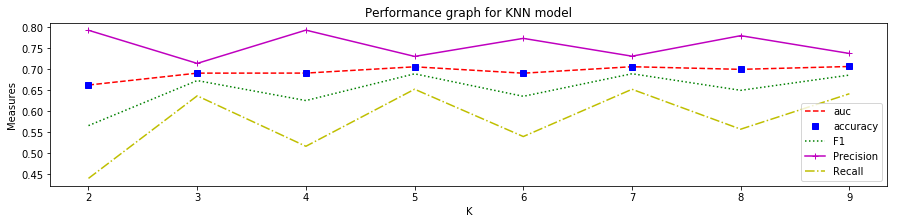

In [9]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.xlabel('K')
plt.ylabel('Measures')
plt.title('Performance graph for KNN model')
plt.plot(KNN_performance_df.k_neighbors, KNN_performance_df.auc, 'r--', 
         KNN_performance_df.k_neighbors, KNN_performance_df.accuracy, 'bs', 
         KNN_performance_df.k_neighbors, KNN_performance_df.f1, 'g:', 
         KNN_performance_df.k_neighbors, KNN_performance_df.precision, 'm-+', 
         KNN_performance_df.k_neighbors, KNN_performance_df.recall, 'y-.')
plt.gca().legend(('auc','accuracy', 'F1', 'Precision', 'Recall'))
plt.show()

### SVC

In [10]:
std_scale_x = preprocessing.StandardScaler().fit(x_with_inactive_days)
x = std_scale_x.transform(x_with_inactive_days)
auc = []
accuracy = []
f1 = []
recall = []
precision = []
kernel = []
splits = 10

sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.25)
for K in ["rbf", "poly", "linear"]:
    print(K)
    temp_auc = []
    temp_accuracy = []
    temp_f1 = []
    temp_recall = []
    temp_precision = []
    for train_index, test_index in sss.split(x, y):
        X_train, X_dev = x[train_index], x[test_index]
        Y_train, Y_dev = y.iloc[train_index], y.iloc[test_index]
        if K == 'linear':
            neigh = LinearSVC(random_state=1)
        else:
            neigh = SVC(kernel=K, random_state=1, probability=True)
        neigh.fit(X_train, Y_train) 
        y_pred = neigh.predict(X_dev)
        
        tn, fp, fn, tp = confusion_matrix(Y_dev, y_pred).ravel()
        Precision = tp/(tp+fp)
        Recall = tp/(tp+fn)
        F1 = 2 * (Precision * Recall) / (Precision + Recall)
        fpr, tpr, thresholds = metrics.roc_curve(Y_dev, y_pred)
        temp_auc.append(metrics.auc(fpr, tpr))
        temp_accuracy.append(accuracy_score(Y_dev, y_pred))
        temp_f1.append(F1)
        temp_recall.append(Recall)
        temp_precision.append(Precision)
    
    auc.append(np.mean(temp_auc))
    accuracy.append(np.mean(temp_accuracy))
    f1.append(np.mean(temp_f1))
    recall.append(np.mean(temp_recall))
    precision.append(np.mean(temp_precision))
    kernel.append(K)

SVC_performance_df = pd.DataFrame({'auc': auc, 'accuracy': accuracy, 'f1': f1, 'recall': recall, 'precision': precision, 'kernel': kernel})

print(SVC_performance_df)


rbf
poly
linear
   accuracy       auc        f1  kernel  precision    recall
0  0.825977  0.825980  0.820330     rbf   0.847814  0.794932
1  0.562408  0.562575  0.286162    poly   0.777697  0.175851
2  0.631679  0.631674  0.637550  linear   0.627625  0.648489


### Graphical view for the performance of KNN model

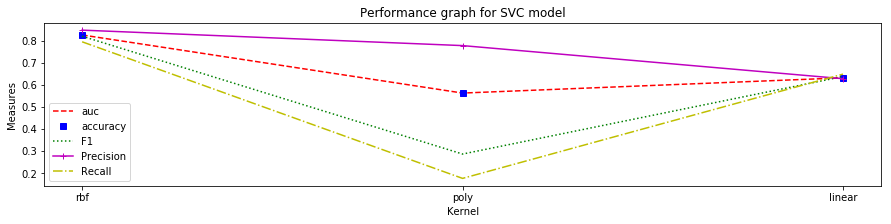

In [11]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.xlabel('Kernel')
plt.ylabel('Measures')
plt.title('Performance graph for SVC model')
my_xticks = [0, 1, 2]
plt.xticks(my_xticks, SVC_performance_df.kernel)
plt.plot(my_xticks, SVC_performance_df.auc, 'r--', 
         my_xticks, SVC_performance_df.accuracy, 'bs', 
         my_xticks, SVC_performance_df.f1, 'g:', 
         my_xticks, SVC_performance_df.precision, 'm-+', 
         my_xticks, SVC_performance_df.recall, 'y-.')
plt.gca().legend(('auc','accuracy', 'F1', 'Precision', 'Recall'))
plt.show()

### Voting Classifier 
Consists of three different models -  
Logistic Regression, SVC [kernel="rbf], KNN [n=5]  
Experimented with the feature vector (with & without inactive days)  
Selected different K size for KNN  
Experimented with RBF, linear and poly kernel for SVC 

In [12]:
def voting_classifier(X_train, X_dev, Y_train, Y_dev, n1, n2, n3):
    print('start training...')
    clf1 = LogisticRegression(random_state=1)
    clf2 = SVC(kernel="rbf", random_state=1, probability=True)
    clf3 = KNeighborsClassifier(n_neighbors=5)
    eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('KN', clf3)], voting='soft', n_jobs = -1, weights=[n1, n2, n3])
    eclf.fit(X_train, Y_train) 
    y_pred = eclf.predict(X_dev)
    y_pred_prob = eclf.predict_proba(X_dev)
    print('Training Finished!')
    return y_pred, y_pred_prob

In [19]:
X_train, X_dev, Y_train, Y_dev = cross_validation.train_test_split(x_with_inactive_days, y, test_size=0.1, random_state=42)

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)

# Trying different weights for the 3 models
auc = []
accuracy = []
f1 = []
recall = []
precision = []
classifier = []

for i in range(1, 4):
    for j in range(1, 4):
        for k in range(1, 4):
            if (i == j) & (j == k) & (i != 1):
                continue
            print(i, j, k)
            y_pred, y_pred_prob = voting_classifier(X_train, X_dev, Y_train, Y_dev, n1 = i, n2 = j, n3 = k)

            tn, fp, fn, tp = confusion_matrix(Y_dev, y_pred).ravel()
            Precision = tp/(tp+fp)
            Recall = tp/(tp+fn)
            F1 = 2 * (Precision * Recall) / (Precision + Recall)
            fpr, tpr, thresholds = metrics.roc_curve(Y_dev, y_pred)
            auc.append(metrics.auc(fpr, tpr))
            accuracy.append(accuracy_score(Y_dev, y_pred))
            f1.append(F1)
            recall.append(Recall)
            precision.append(Precision)
            classifier.append('lr '+str(i)+' svc '+str(j)+' KN '+str(k))
            
voting_classifier_performance_df = pd.DataFrame({'auc': auc, 'accuracy': accuracy, 'f1': f1, 'recall': recall, 'precision': precision, 'classifier': classifier})

print(voting_classifier_performance_df)

1 1 1
start training...
Training Finished!
1 1 2
start training...
Training Finished!
1 1 3
start training...
Training Finished!
1 2 1
start training...
Training Finished!
1 2 2
start training...
Training Finished!
1 2 3
start training...
Training Finished!
1 3 1
start training...
Training Finished!
1 3 2
start training...
Training Finished!
1 3 3
start training...
Training Finished!
2 1 1
start training...
Training Finished!
2 1 2
start training...
Training Finished!
2 1 3
start training...
Training Finished!
2 2 1
start training...
Training Finished!
2 2 3
start training...
Training Finished!
2 3 1
start training...
Training Finished!
2 3 2
start training...
Training Finished!
2 3 3
start training...
Training Finished!
3 1 1
start training...
Training Finished!
3 1 2
start training...
Training Finished!
3 1 3
start training...
Training Finished!
3 2 1
start training...
Training Finished!
3 2 2
start training...
Training Finished!
3 2 3
start training...
Training Finished!
3 3 1
start

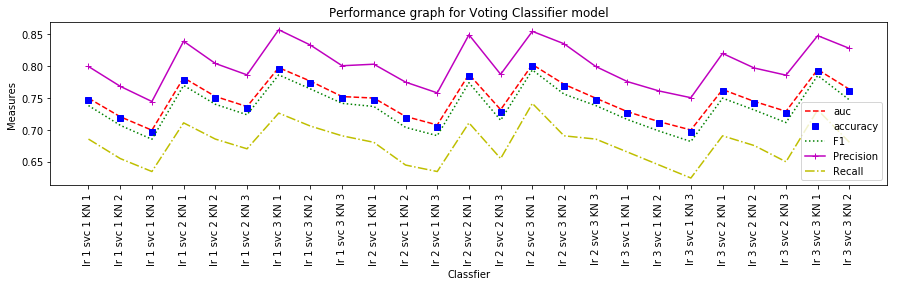

In [20]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.xlabel('Classfier')
plt.ylabel('Measures')
plt.title('Performance graph for Voting Classifier model')
my_xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
plt.xticks(my_xticks, voting_classifier_performance_df.classifier)
plt.plot(my_xticks, voting_classifier_performance_df.auc, 'r--', 
         my_xticks, voting_classifier_performance_df.accuracy, 'bs', 
         my_xticks, voting_classifier_performance_df.f1, 'g:', 
         my_xticks, voting_classifier_performance_df.precision, 'm-+', 
         my_xticks, voting_classifier_performance_df.recall, 'y-.')
plt.gca().legend(('auc','accuracy', 'F1', 'Precision', 'Recall'))
plt.xticks(rotation=90)
plt.show()

The best result is using Voting Classifier with Best Models: RBF SVC, Logistic Regression, and KNN with soft voting [3, 2, 1] having ~0.80 as the final score. 